# Miembros de la pareja 04 del grupo 1472

Javier Fraile Iglesias e Iván Fernández París

In [ ]:
!rm -rf master.zip* nvcc4jupyter-master*
!wget https://github.com/andreinechaev/nvcc4jupyter/archive/refs/heads/master.zip
!unzip master.zip
!cd nvcc4jupyter-master; ls; python setup.py install

In [ ]:
%load_ext nvcc_plugin

# Implementación Stencil 1D (Host)

In [ ]:
%%cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <sys/time.h>
#include <time.h>

#define N 1024
#define RADIUS 3
#define BLOCK_SIZE 40

// CPU stencil_1d function
__host__ void stencil_1d(int *in, int *out){
	int i, j;
  int result=0;

	for(i= 0; i < N; i++){
		result = 0;
		for (j=-RADIUS; j<=RADIUS; j++){
			if(i+j>0 && i+j<N){
				result += in[i+j];
			}
		}
		out[i]= result;
	}
	
}

int main(void) {
    int i;
    int *array_1D, *result;
    int size = N*sizeof(int);
    struct timeval ini_time, fin_time;
    double diff_time = 0.0;

    array_1D = (int*)malloc(size);
    for(i=0; i < N; i++)
      array_1D[i] = 1;
  
    result = (int*)malloc(size);

    // Time initialize
    gettimeofday(&ini_time, NULL);

    // Launch stencil_1d() on CPU
    stencil_1d(array_1D, result);
    
    // Time stop and calculate diff time
    gettimeofday(&fin_time, NULL);
    diff_time += ((fin_time.tv_sec*1000000+fin_time.tv_usec)-
                      (ini_time.tv_sec*1000000+ini_time.tv_usec))*1.0/1000000.0;

    printf("\nTiempo de ejecución que se obtiene con la CPU: %f", diff_time);

    // Cleanup
    free(array_1D);
    free(result);
		return 0;
}


Tiempo de ejecución que se obtiene con la CPU: 0.000021


# Implementación Stencil 1D (Device)

In [ ]:
%%cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <sys/time.h>
#include <time.h>

#define N 1024
#define RADIUS 3
#define BLOCK_SIZE 40

// GPU stencil_1d function
__global__ void stencil_1d(int *in, int *out) {
  __shared__ int temp[BLOCK_SIZE + 2 * RADIUS];
  int gindex = threadIdx.x + blockIdx.x * blockDim.x;
  int lindex = threadIdx.x + RADIUS;
  
  // Read input elements into shared memory
  temp[lindex] = in[gindex];
  if (threadIdx.x < RADIUS) {
    if(gindex - RADIUS < 0){
        temp[lindex-RADIUS] =0;
    } else{
        temp[lindex - RADIUS] = in[gindex - RADIUS];
    }

    if(gindex+BLOCK_SIZE >=N){
        temp[lindex + BLOCK_SIZE]=0;
      }else{
        temp[lindex + BLOCK_SIZE] = in[gindex + BLOCK_SIZE];
    }
  }
 
  // Synchronize
  __syncthreads();

  // Apply the stencil
  int result = 0;
  for (int offset = -RADIUS ; offset <= RADIUS ; offset++){
    result += temp[lindex + offset];
  }

  // Store the result
  out[gindex] = result;
}

int main(void) {
    int i;
    int *array_1D, *result, *d_array_1D, *d_result; // variables para el device
    int size = (N + 2*RADIUS) * sizeof(int);
    struct timeval ini_time, fin_time;
    double diff_time = 0.0;

    // Alloc space for host copies and setup values
    array_1D = (int *)malloc(size); 
    for(i=0; i < N+2*RADIUS; i++)
      array_1D[i] = 1;
  
    result = (int*)malloc(size);

    // Alloc space for device copies
    cudaMalloc((void **)&d_array_1D, size);
	  cudaMalloc((void **)&d_result, size);

    // Time initialize
    gettimeofday(&ini_time, NULL);

    // Copy to device 
	  cudaMemcpy(d_array_1D, array_1D, size, cudaMemcpyHostToDevice);

    // Launch stencil_1d() kernel on GPU
		stencil_1d<<<(N+BLOCK_SIZE-1)/BLOCK_SIZE, BLOCK_SIZE>>>(d_array_1D+RADIUS, d_result+RADIUS);
    
    // Copy result back to host
    cudaMemcpy(result, d_result, size, cudaMemcpyDeviceToHost);
    
    // Time stop and calculate diff time
    gettimeofday(&fin_time, NULL);
    diff_time += ((fin_time.tv_sec*1000000+fin_time.tv_usec)-
                      (ini_time.tv_sec*1000000+ini_time.tv_usec))*1.0/1000000.0;

    printf("\nTiempo de ejecución que se obtiene con la GPU: %f", diff_time);

    // Cleanup
    free(array_1D);
    free(result);
    cudaFree(d_array_1D);
    cudaFree(d_result);
		return 0;
}

# Implementación Stencil 1D (Device y Host en una misma función)

In [ ]:
%%cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <sys/time.h>
#include <time.h>

#define BLOCK_SIZE 40
#define RADIUS 3
#define N 1000000

__host__ int validate(int *a,int *b,int n,int *orig){
		 int i;
			for(i = 0; i < n; i++){
					if (a[i]!=b[i])
		 			{ 
						 	printf("Error en %d GPU: %d HOST:%d\n",i,a[i],b[i]);
							for (int k=-RADIUS;k<=RADIUS;k++){
									if (i+k >= 0 && i+k < n) {
									printf("%d:%d ",i+k,orig[i+k]);
								}

							}
							printf("\n");
		 					return -1;
					}
			}
			return 0;
}

// CPU stencil_1d function
__host__ void stencil_1d_CPU(int *in, int *out){
	int i, j;
  int result=0;

	for(i= 0; i < N; i++){
		result = 0;
		for (j=-RADIUS; j<=RADIUS; j++){
			if(i+j>=0 && i+j<N){
				result += in[i+j];
			}
		}
		out[i]= result;
	}

}

// GPU stencil_1d function
__global__ void stencil_1d_GPU(int *in, int *out) {
  __shared__ int temp[BLOCK_SIZE + 2 * RADIUS];
  int gindex = threadIdx.x + blockIdx.x * blockDim.x;
  int lindex = threadIdx.x + RADIUS;

  // Read input elements into shared memory
  temp[lindex] = in[gindex];
  if (threadIdx.x < RADIUS) {
    if(gindex - RADIUS < 0){
        temp[lindex-RADIUS] = 0;
    } else{
        temp[lindex - RADIUS] = in[gindex - RADIUS];
    }

    if(gindex+BLOCK_SIZE >=N){
        temp[lindex + BLOCK_SIZE]= 0;
      }else{
        temp[lindex + BLOCK_SIZE] = in[gindex + BLOCK_SIZE];
    }
  }

  // Synchronize
  __syncthreads();

  // Apply the stencil
  int result = 0;
  for (int offset = -RADIUS ; offset <= RADIUS ; offset++){
    result += temp[lindex + offset];
  }

  // Store the result
  out[gindex] = result;
}

int main(void) {
    int i;
    int *array_1D_GPU, *result_GPU, *d_array_1D_GPU, *d_result_GPU; // device variables
    int *array_1D_CPU, *result_CPU; // host variables
    int size_GPU = (N + 2*RADIUS)*sizeof(int);
    int size_CPU = N*sizeof(int);
    struct timeval ini_time_GPU, fin_time_GPU, ini_time_CPU, fin_time_CPU;
    double diff_time_CPU = 0.0, diff_time_GPU = 0.0;

    // Alloc space for host copies and setup values
    array_1D_GPU = (int *)malloc(size_GPU);
    for(i=0; i < N+2*RADIUS; i++)
      array_1D_GPU[i] = 1;

    result_GPU = (int*)malloc(size_GPU);

		// Alloc space for device copies
    cudaMalloc((void **)&d_array_1D_GPU, size_GPU);
	  cudaMalloc((void **)&d_result_GPU, size_GPU);

    array_1D_CPU = (int*)malloc(size_CPU);
    for(i=0; i < N; i++)
      array_1D_CPU[i] = 1;

    result_CPU = (int*)malloc(size_CPU);

		// GPU ime initialize
    gettimeofday(&ini_time_GPU, NULL);

		// Copy to device
    cudaMemcpy(d_array_1D_GPU, array_1D_GPU, size_GPU, cudaMemcpyHostToDevice);

		// Launch stencil_1d() kernel on GPU
		stencil_1d_GPU<<<(N+BLOCK_SIZE-1)/BLOCK_SIZE, BLOCK_SIZE>>>(d_array_1D_GPU+RADIUS, d_result_GPU+RADIUS);
    
		// Copy result back to host
		cudaMemcpy(result_GPU, d_result_GPU, size_GPU, cudaMemcpyDeviceToHost);
    
		// GPU time stop and calculate diff time
		gettimeofday(&fin_time_GPU, NULL);
    diff_time_GPU += ((fin_time_GPU.tv_sec*1000000+fin_time_GPU.tv_usec)-
                      (ini_time_GPU.tv_sec*1000000+ini_time_GPU.tv_usec))*1.0/1000000.0;

    printf("\nTiempo de ejecución que se obtiene con la GPU: %f", diff_time_GPU);

		// CPU ime initialize
    gettimeofday(&ini_time_CPU, NULL);

		// Launch stencil_1d() kernel on host
    stencil_1d_CPU(array_1D_CPU, result_CPU);

		// CPU time stop and calculate diff time
    gettimeofday(&fin_time_CPU, NULL);
    diff_time_CPU += ((fin_time_CPU.tv_sec*1000000+fin_time_CPU.tv_usec)-
                      (ini_time_CPU.tv_sec*1000000+ini_time_CPU.tv_usec))*1.0/1000000.0;

    printf("\nTiempo de ejecución que se obtiene con la CPU: %f\n", diff_time_CPU);

    validate(result_GPU+RADIUS,result_CPU,N,array_1D_CPU);

		// Cleanup
    free(array_1D_GPU);
    free(result_GPU);
    free(array_1D_CPU);
    free(result_CPU);
    cudaFree(d_array_1D_GPU);
    cudaFree(d_result_GPU);
		return 0;
}


Tiempo de ejecución que se obtiene con la GPU: 0.003745
Tiempo de ejecución que se obtiene con la CPU: 0.022037



# Tiempos obtenidos según el tamaño del 1D array

| array size | Time_GPU | Time_CPU |
|------------|----------|----------|
|  100.000   |0.000552  |0.003133  |
|  200.000   |0.000991  |0.004164  |
|  300.000   |0.001330  |0.005953  |
|  400.000   |0.001636  |0.007920  |
|  500.000   |0.002140  |0.010015  |
|  600.000   |0.002438  |0.012125  |
|  700.000   |0.002665  |0.014314  |
|  800.000   |0.003099  |0.016748  |
|  900.000   |0.003468  |0.018392  |
| 1.000.000  |0.003826  |0.021419  |

# Gráfica con los tiempos de ejecución en device y host 


In [ ]:
# ! pip install matplotlib

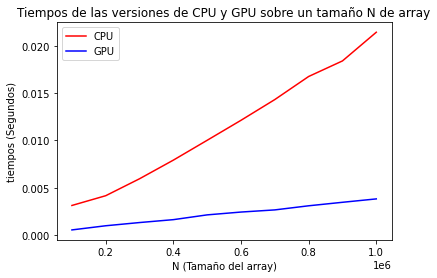

In [ ]:
import matplotlib.pyplot as plt 

N = [i*100000 for i in range(1, 11)]

times_GPU = [0.000552, 0.000991, 0.001330, 0.001636, 0.002140, 0.002438, 0.002665, 0.003099, 0.003468, 0.003826]
times_CPU = [0.003133, 0.004164, 0.005953, 0.007920, 0.010015, 0.012125, 0.014314, 0.016748, 0.018392, 0.021419]

plt.plot(N, times_CPU, color="red", label="CPU")
plt.plot(N, times_GPU, color="blue",label="GPU")


plt.legend(loc = "upper left")

plt.xlabel("N (Tamaño del array)")
plt.ylabel("tiempos (Segundos)")
plt.title("Tiempos de las versiones de CPU y GPU sobre un tamaño N de array")

plt.show()